In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sns
import time

In [3]:
import spacy
import numpy as np
import pt_core_news_sm

In [4]:
from os import listdir
from os.path import isfile, join

## Load raw database

In [9]:
mypath = 'data/search_result/'

In [10]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [11]:
onlyfiles

['temp_result_21_03_2020-04_05_2020.csv',
 'temp_result_01_01_2020-21_03_2020.csv',
 'temp_result_05_05_2020-23_08_2020.csv']

In [14]:
df_news = pd.DataFrame()
for file in onlyfiles:
    temp = pd.read_csv("{}{}".format(mypath,file))
    df_news = pd.concat([df_news,temp])

## Data filter

In [15]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17258 entries, 0 to 6775
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     17258 non-null  object
 1   media     16742 non-null  object
 2   date      17258 non-null  object
 3   datetime  17258 non-null  object
 4   desc      17258 non-null  object
 5   link      17258 non-null  object
 6   img       17258 non-null  object
 7   keyword   17258 non-null  object
dtypes: object(8)
memory usage: 1.2+ MB


In [16]:
df_news[df_news.duplicated(subset = ['link'])]['link']

16      https://www.canalrural.com.br/radar/bolsonaro-...
17      https://www.jornaldocomercio.com/_conteudo/eco...
18      https://www.gaz.com.br/momento-instavel-preocu...
19      https://revistagloborural.globo.com/Noticias/n...
23      https://www.diariodecuiaba.com.br/cidades/secr...
                              ...                        
6771    https://www.canalrural.com.br/noticias/tempo/p...
6772    https://www.portosenavios.com.br/noticias/nave...
6773    https://www.portalondasul.com.br/produtores-co...
6774    https://www.portosenavios.com.br/noticias/nave...
6775    https://www.portosenavios.com.br/noticias/nave...
Name: link, Length: 7836, dtype: object

In [17]:
df_news['keyword'].value_counts()

milho                 2181
soja                  2132
"soja mercado"        1924
"safra soja"          1730
"soja exportação"     1623
"soja santos"         1269
"soja verde"          1265
"soja futuro"         1188
"prêmio soja"         1143
fertilizante           582
"soja chicago"         532
"soja paranaguá"       353
"frete soja"           280
"soja B3"              279
"relatório usda"       182
"esmagamento soja"     175
"relatório conab"      134
"soja balcão"           82
"moagem soja"           62
"soja arco norte"       56
milheto                 55
"soja FOB"              14
"envase soja"           13
"soja CIF"               4
Name: keyword, dtype: int64

### Remove duplicates links

Multiple keywords can lead to the same news

In [18]:
df_news = df_news.drop_duplicates(subset = ['link'])

In [19]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9422 entries, 0 to 6746
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     9422 non-null   object
 1   media     9150 non-null   object
 2   date      9422 non-null   object
 3   datetime  9422 non-null   object
 4   desc      9422 non-null   object
 5   link      9422 non-null   object
 6   img       9422 non-null   object
 7   keyword   9422 non-null   object
dtypes: object(8)
memory usage: 662.5+ KB


In [20]:
df_news = df_news[['keyword','title','desc','media','date','datetime', 'link']]
df_news['datetime'] = pd.to_datetime(df_news['datetime'] , format='%Y-%m-%d')
df_news = df_news[df_news['datetime'] <= pd.to_datetime('2021-05-01' , format='%Y-%m-%d')]

In [21]:
df_news.head()

,keyword,title,desc,media,date,datetime,link
0,soja,Fundador do Instituto Ling morre aos 99 anos,Sheun Ming Ling foi um dos pioneiros da soja n...,Jornal do Comércio,"Mar 21, 2020",2020-03-21,https://www.jornaldocomercio.com/_conteudo/eco...
1,soja,Bolsonaro: Assinei MP deixando claro que fecha...,Busca · Notícias · Pecuária · Agricultura · Te...,NaN,"Mar 21, 2020",2020-03-21,https://www.canalrural.com.br/radar/bolsonaro-...
2,soja,Coronavírus: como manter o sistema imune forte...,"Feijão, soja, frutos secos como amêndoas, amen...",Revista Globo Rural,"Mar 21, 2020",2020-03-21,https://revistagloborural.globo.com/Noticias/n...
3,soja,Secretaria confirma segundo caso de coronavíru...,"Soja e milho, com preços altos, avançam sobre ...",Diario de Cuiabá,"Mar 21, 2020",2020-03-21,https://www.diariodecuiaba.com.br/cidades/secr...
4,soja,Recupere o viço da pele: saiba o que incluir n...,"Os grãos integrais das leguminosas, como feijõ...",Marie Claire,"Mar 21, 2020",2020-03-21,https://revistamarieclaire.globo.com/Beleza/no...


In [22]:
df_news.to_csv('data/norm_base_2021.csv', index = None)

### Craw full headline

In [23]:
def check_if_incomplete(headline):
    if '...' in headline:
        return True
    return False

In [24]:
df_news["title_incomplete"] = df_news['title'].astype(str).map(lambda a: check_if_incomplete(a))

In [25]:
df_news["title_incomplete"].value_counts()

False    7436
True     1977
Name: title_incomplete, dtype: int64

In [26]:
import requests
from bs4 import BeautifulSoup

In [16]:
def get_head_line_title(df):
    size = len(df)
    count = 1
    complete_title = []
    old = -1
    for index,row in df.iterrows():
        if row['title_incomplete']:
            try:
                page = requests.get(row['link']).text
                soup = BeautifulSoup(page)
                complete_title.append(soup.find('title').get_text())
            except:
                complete_title.append(row['title'])
            count += 1
            
            step = int((count/size)*100)
            if step % 5 == 0 and step != old:
                print(step)
                old = step
            time.sleep(2)
        else:
            complete_title.append(row['title'])
    df['complete_title'] = complete_title        
    return df

In [17]:
%%time
df_news_cw = get_head_line_title(df_news)

0
5
10
15
20
CPU times: user 1min 49s, sys: 2.28 s, total: 1min 51s
Wall time: 1h 21min 20s


In [62]:
df_news_cw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7155 entries, 0 to 7154
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   keyword           7155 non-null   object        
 1   title             7155 non-null   object        
 2   desc              7155 non-null   object        
 3   media             6784 non-null   object        
 4   date              7155 non-null   object        
 5   datetime          7155 non-null   datetime64[ns]
 6   link              7155 non-null   object        
 7   title_incomplete  7155 non-null   bool          
 8   complete_title    7155 non-null   object        
 9   real_a_vista      5422 non-null   float64       
 10  dolar_a_vista     5422 non-null   float64       
 11  real_diff         5422 non-null   float64       
 12  dolar_diff        5422 non-null   float64       
 13  real_5            5422 non-null   float64       
 14  real_14           5422 n

In [60]:
def get_final_headline(headline1, headline2):
    if len(headline1) >= len(headline2):
        return headline1
    return headline2

In [61]:
df_news_cw['norm_title'] = df_news_cw.apply(lambda a: get_final_headline(a.title,a.complete_title), axis=1)

In [63]:
df_news_cw.to_csv('data/norm_base_cw_title.csv', index = None)

## Plots

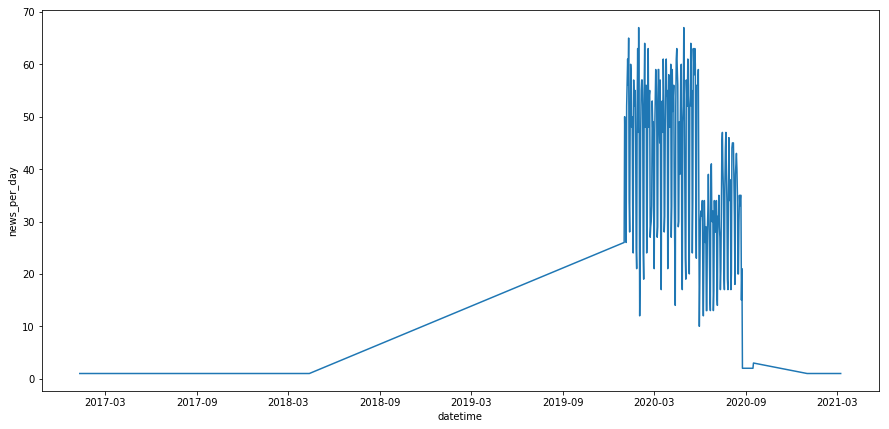

In [27]:
plt.figure(figsize=(15,7))

df_by = df_news.groupby(["datetime"]).agg(news_per_day = ('title', 'count'))
df_by = df_by.reset_index()
ax1 = sns.lineplot(x = "datetime", y = "news_per_day", data = df_by)


In [28]:
temp = df_news.copy()
temp['day_of_week'] = temp['datetime'].dt.dayofweek
temp['week'] = temp['datetime'].dt.week
temp['year'] = temp['datetime'].dt.year
df_by = temp.groupby(["day_of_week", "week", "year"]).agg(news_per_day = ('title', 'count'))
df_by = df_by.reset_index()
df_by = df_by.groupby(['day_of_week']).agg(news_w_day = ('news_per_day', 'mean'))
df_by['day_week'] = ['mon','tue','wed','thu','fri','sat','sun']

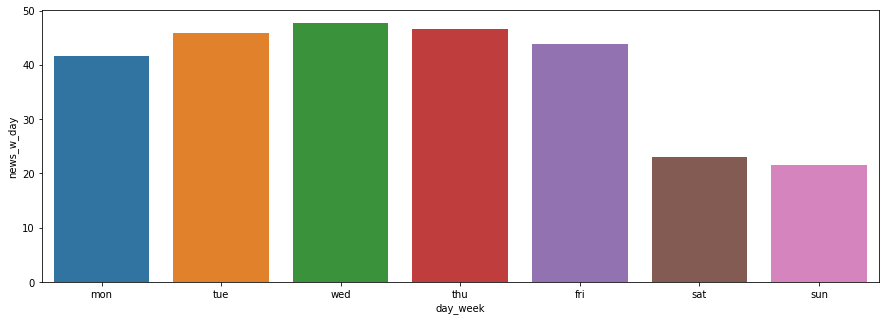

In [29]:
plt.figure(figsize=(15,5))
ax1 = sns.barplot(x = "day_week", y = "news_w_day", data = df_by)

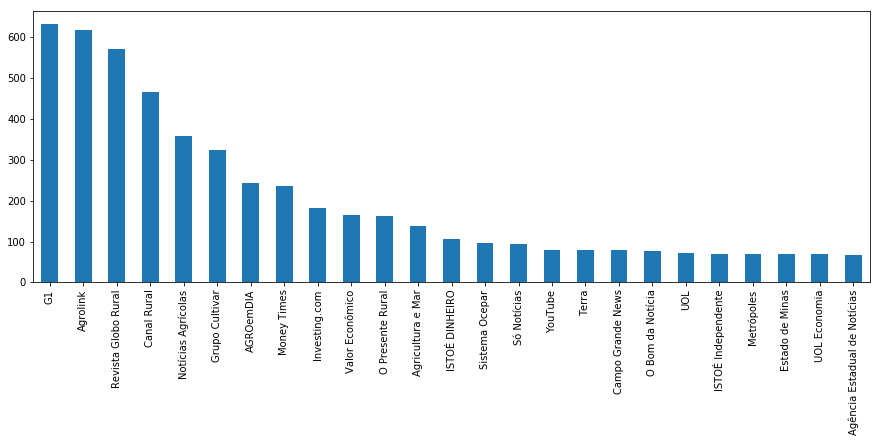

In [30]:
plt.figure(figsize=(15,5))
df_news['media'].value_counts()[:25].plot(kind = 'bar')

## Price

In [31]:
price_list = pd.read_excel('data/soja_paranagua.xls')
price_list = price_list.rename(columns={"À vista R$": "real_a_vista", "À vista US$": "dolar_a_vista", "Data": "datetime"})
price_list['datetime'] = pd.to_datetime(price_list['datetime'] , format='%d/%m/%Y')

### add some price features

In [32]:
temp = price_list.copy()
real_diff = temp[1:]['real_a_vista'].values - temp[:-1]['real_a_vista'].values
dolar_diff = temp[1:]['dolar_a_vista'].values - temp[:-1]['dolar_a_vista'].values
price_list = price_list[1:]
price_list['real_diff'] = real_diff
price_list['dolar_diff'] = dolar_diff

In [33]:
price_list['real_5'] = price_list['real_a_vista'].rolling(5).mean()
price_list['real_14'] = price_list['real_a_vista'].rolling(14).mean()
price_list['real_21'] = price_list['real_a_vista'].rolling(21).mean()

price_list['dolar_5'] = price_list['dolar_a_vista'].rolling(5).mean()
price_list['dolar_14'] = price_list['dolar_a_vista'].rolling(14).mean()
price_list['dolar_21'] = price_list['dolar_a_vista'].rolling(21).mean()

In [34]:
df_news_cw = df_news.merge(price_list, on = 'datetime',how = 'left')

In [93]:
df_news_cw.to_csv("data/norm_base_cw_title.csv")

In [35]:
df_news_cw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9413 entries, 0 to 9412
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   keyword           9413 non-null   object        
 1   title             9413 non-null   object        
 2   desc              9413 non-null   object        
 3   media             9145 non-null   object        
 4   date              9413 non-null   object        
 5   datetime          9413 non-null   datetime64[ns]
 6   link              9413 non-null   object        
 7   title_incomplete  9413 non-null   bool          
 8   real_a_vista      7671 non-null   float64       
 9   dolar_a_vista     7671 non-null   float64       
 10  real_diff         7671 non-null   float64       
 11  dolar_diff        7671 non-null   float64       
 12  real_5            7671 non-null   float64       
 13  real_14           7671 non-null   float64       
 14  real_21           7671 n

### Check prices during period

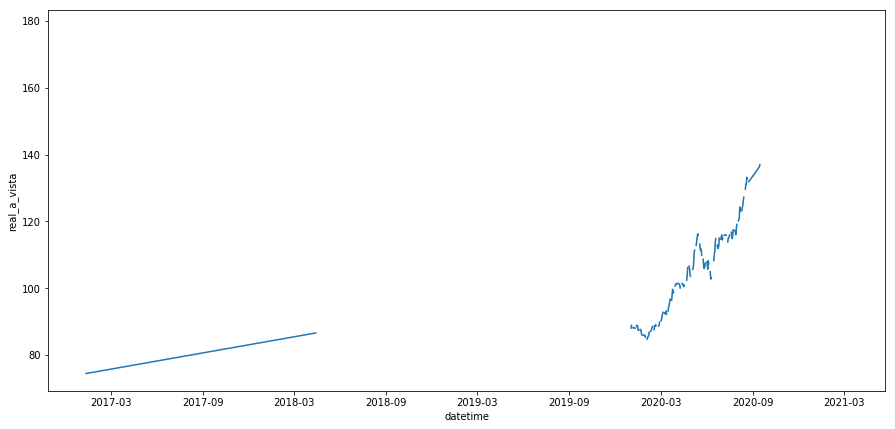

In [36]:
plt.figure(figsize=(15,7))
ax1 = sns.lineplot(x = "datetime", y = "real_a_vista", data = df_news_cw)

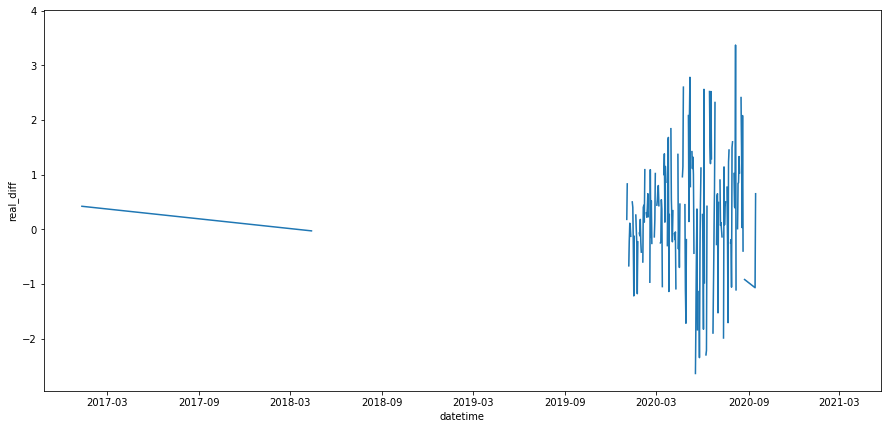

In [37]:
plt.figure(figsize=(15,7))
ax1 = sns.lineplot(x = "datetime", y = "real_diff", data = df_news_cw)

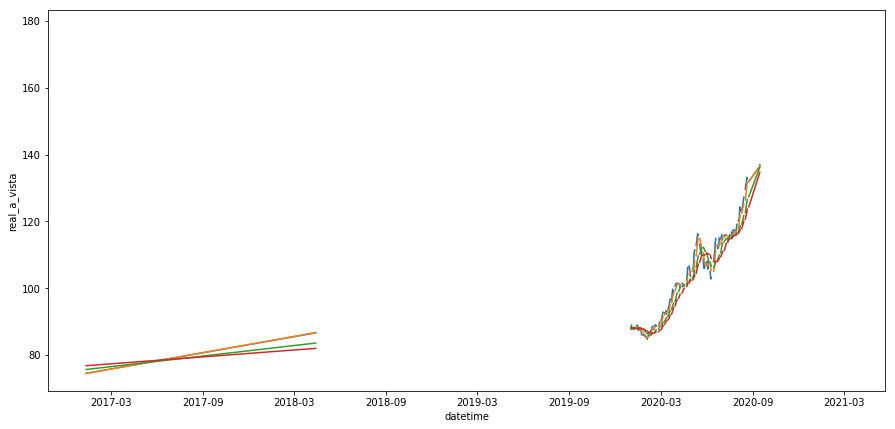

In [38]:
plt.figure(figsize=(15,7))
ax1 = sns.lineplot(x = "datetime", y = "real_a_vista", data = df_news_cw)
ax2 = sns.lineplot(x = "datetime", y = "real_5", data = df_news_cw)
ax3 = sns.lineplot(x = "datetime", y = "real_14", data = df_news_cw)
ax3 = sns.lineplot(x = "datetime", y = "real_21", data = df_news_cw)

## Text vectorize nlp

In [39]:
from spacy.lang.pt.stop_words import STOP_WORDS
nlp = spacy.load("pt_core_news_sm")

In [40]:
def get_tokens(text, candidate_pos = ['NOUN','PRON','VERB', 'AUX']):   
    
    sentences = []        
    count_token = {}
    
    set_token = set()

    doc = nlp(text)
    
    for sent in doc.sents:
        for token in sent:
            if token.pos_ in candidate_pos and token.is_stop is False:
                set_token.add(token.lemma_)
                if token.lemma_ in count_token.keys():
                    count_token[token.lemma_] += 1
                else:
                    count_token[token.lemma_] = 1
    
    return count_token, set_token

In [41]:
df_news_cw['title'].values[7]

'O ataque do “03” à China e às lições da história sobre a gripe espanhola'

In [42]:
get_tokens(df_news_cw['title'].values[7])[0]

{'atacar': 1, 'lição': 1, 'história': 1}

## Word count

In [43]:
from wordcloud import WordCloud

In [44]:
def check_up(real_diff):
    if real_diff > 0:
        return True
    return False

In [45]:
df_news_cw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9413 entries, 0 to 9412
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   keyword           9413 non-null   object        
 1   title             9413 non-null   object        
 2   desc              9413 non-null   object        
 3   media             9145 non-null   object        
 4   date              9413 non-null   object        
 5   datetime          9413 non-null   datetime64[ns]
 6   link              9413 non-null   object        
 7   title_incomplete  9413 non-null   bool          
 8   real_a_vista      7671 non-null   float64       
 9   dolar_a_vista     7671 non-null   float64       
 10  real_diff         7671 non-null   float64       
 11  dolar_diff        7671 non-null   float64       
 12  real_5            7671 non-null   float64       
 13  real_14           7671 non-null   float64       
 14  real_21           7671 n

In [46]:
df_news_cw["upper_trend"] = df_news_cw['real_diff'].map(lambda a: check_up(a))

In [47]:
df_news_cw["upper_trend"].value_counts()

True     4731
False    4682
Name: upper_trend, dtype: int64

In [49]:
words_up = df_news_cw.query("upper_trend == True")['title'].sum()
words_down = df_news_cw.query("upper_trend == False")['title'].sum()

In [50]:
%%time
word_count_up = get_tokens(words_up)[0]
word_count_down = get_tokens(words_down)[0]

CPU times: user 15 s, sys: 1.72 s, total: 16.8 s
Wall time: 16.8 s


In [51]:
len(word_count_up.keys())

4692

In [52]:
len(word_count_down.keys())

4866

(-0.5, 399.5, 199.5, -0.5)

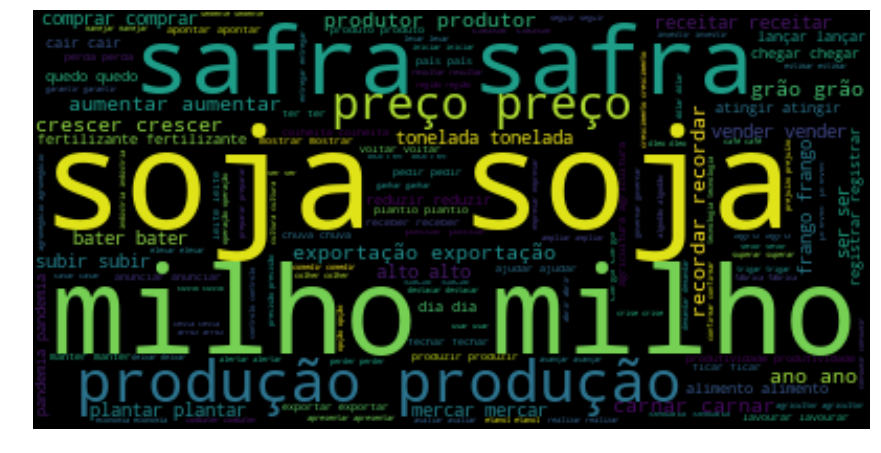

In [53]:
plt.figure(figsize=(15,15))
fake_text = ''
for word in word_count_up.keys():
    for x in range(0,word_count_up[word]):
        fake_text += word + ' '
wordcloud = WordCloud().generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

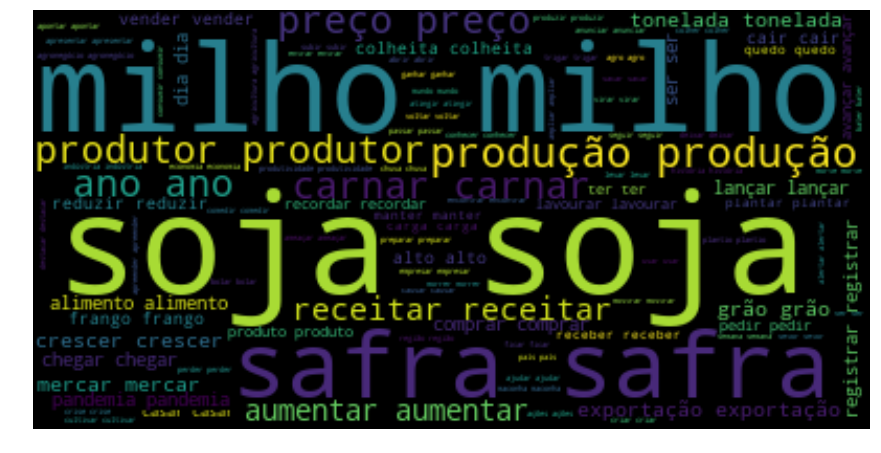

In [54]:
plt.figure(figsize=(15,15))
fake_text = ''
for word in word_count_down.keys():
    for x in range(0,word_count_down[word]):
        fake_text += word + ' '
wordcloud = WordCloud().generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Only soja related keywords

In [97]:
df_news_cw_soja = df_news_cw.query("keyword == 'soja' or keyword == 'soja preço' or keyword == 'soja mercado'")

In [99]:
words_up = df_news_cw_soja.query("upper_trend == True")['norm_title'].sum()
words_down = df_news_cw_soja.query("upper_trend == False")['norm_title'].sum()

In [100]:
%%time
word_count_up = get_tokens(words_up)[0]
word_count_down = get_tokens(words_down)[0]

CPU times: user 4.24 s, sys: 131 ms, total: 4.37 s
Wall time: 4.37 s


(-0.5, 399.5, 199.5, -0.5)

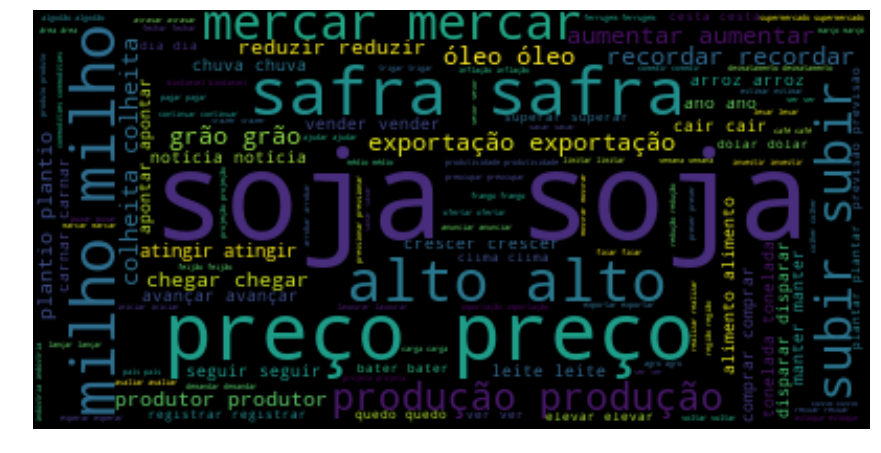

In [101]:
plt.figure(figsize=(15,15))
fake_text = ''
for word in word_count_up.keys():
    for x in range(0,word_count_up[word]):
        fake_text += word + ' '
wordcloud = WordCloud().generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

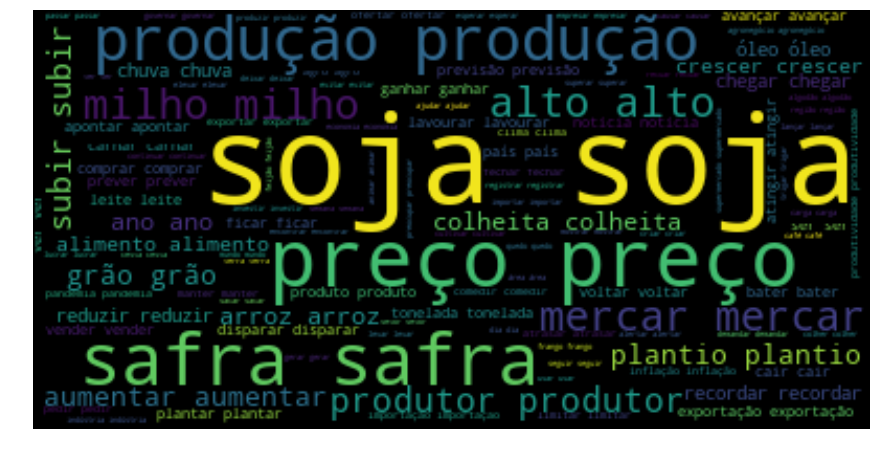

In [102]:
plt.figure(figsize=(15,15))
fake_text = ''
for word in word_count_down.keys():
    for x in range(0,word_count_down[word]):
        fake_text += word + ' '
wordcloud = WordCloud().generate(fake_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")